# Zadanie 3

## Sudoku


In [1]:
import random
import time
import os.path

from copy import deepcopy
from matplotlib import pyplot as plt
from random import randrange
from termcolor import colored

## Strategy

### Guessing

In each 3x3 quare we fill randomly empty slots, so that there are no 2 same numbers.

### Swaping

In each iteration we choose random square and inside it, we swap 2 random guessed numbers. Numbers are not moved between squares.

### Counting score

Since there will never be 2 same numbers in a square, we care only about rows and colums. Each duplicated number in row/column adds 1 point to the score

### Number of iterations

Since in this excercise we clearly know if we found the optimal state, we do not limit ourselves by maximal number of iterations. The solving process will last as long as it requires to fully solve sudoku.

### modus operandi

By testing I decided to follow the following way of acting: Single simulation takes at most 8,000 operations. After that the odds of finding a sollution are very low (because the low temperature makes us stuck in a local minimum), so we reset the temperature function while keeping the current state. That gives us an oportunity to escape local minimum without loosing progress. If after 60,000 iterations in total we didn't find the sollution, then that means that we are really stuck in a state that has low score but is far from the sollution. We restart the whole state (pick again numbers at random) and start all over again.


In [2]:
def read_sudoku_from_file(filename):
    file = open(filename, "r")
    sudoku = []
    for line in file.readlines():
        sudoku.append([])
        for char in line:
            if char in "123456789x":
                sudoku[-1].append(None if char == "x" else char)
    file.close()
    return sudoku

In [3]:
def randomly_fill_sudoku(sudoku):
    guesses = []
    for row in range(3):
        for column in range(3):
            available = [True for _ in range(9)]
            empty = []
            for i in range(9):
                y = 3 * row + (i // 3)
                x = 3 * column + (i % 3)
                char = sudoku[y][x]
                if char is None:
                    empty.append((x, y))
                else:
                    available[ord(char) - ord("1")] = False
            for x, y in empty:
                index = randrange(9)
                while not available[index]:
                    index = (index + 1) % 9
                available[index] = False
                sudoku[y][x] = chr(index + ord("1"))

            if len(empty) > 1:
                guesses.append(empty)
    return guesses

In [4]:
def calculate_score(sudoku):
    score = 0
    # Rows
    for row in sudoku:
        used = [False for _ in range(9)]
        for char in row:
            index = ord(char) - ord("1")
            if used[index]:
                score += 1
            used[index] = True
    # Columns
    for x in range(9):
        used = [False for _ in range(9)]
        for y in range(9):
            index = ord(sudoku[y][x]) - ord("1")
            if used[index]:
                score += 1
            used[index] = True
    return score

In [5]:
def print_sudoku(sudoku, solved_sudoku=None):
    # for row in sudoku:
    for y in range(9):
        # for char in row:
        for x in range(9):
            char = sudoku[y][x]
            if solved_sudoku is None:
                print(char if char is not None else "_", end=" ")
            else:
                if char is not None:
                    print(char, end=" ")
                else:
                    print(colored(solved_sudoku[y][x], color="red"), end=" ")
        print()

In [6]:
def simulation(sudoku, guesses, max_iterations, temp_exponent, acceptance_factor):
    results = []
    current_energy = calculate_score(sudoku)

    temperature = 1

    for i in range(max_iterations):
        (x1, y1), (x2, y2) = random.choices(population=random.choice(guesses), k=2)
        sudoku[y1][x1], sudoku[y2][x2] = sudoku[y2][x2], sudoku[y1][x1]

        temperature *= temp_exponent

        new_energy = calculate_score(sudoku)
        if (
            new_energy - current_energy
        ) * random.random() < acceptance_factor * temperature:
            current_energy = new_energy
        # Revert changes
        else:
            sudoku[y1][x1], sudoku[y2][x2] = sudoku[y2][x2], sudoku[y1][x1]

        results.append(current_energy)
        # if i % 10 == 0:
        #     print(f'{i}: {current_energy}')
        if current_energy <= 0:
            return results, True
    return results, False

In [7]:
ONE_TIME_ITERATIONS = 8_000
ITERATIONS_TO_RESTART = 60_000


def solve(sudoku):
    original_sudoku = deepcopy(sudoku)
    results = []
    guesses = randomly_fill_sudoku(sudoku)

    iterations_left = ITERATIONS_TO_RESTART
    is_solved = False
    while not is_solved:
        if iterations_left < 0:
            sudoku = deepcopy(original_sudoku)
            guesses = randomly_fill_sudoku(sudoku)
            iterations_left = ITERATIONS_TO_RESTART

        new_results, is_solved = simulation(
            sudoku,
            guesses,
            max_iterations=ONE_TIME_ITERATIONS,
            temp_exponent=0.9995,
            acceptance_factor=0.02,
        )
        iterations_left -= ONE_TIME_ITERATIONS
        results += new_results
    return results

In [8]:
def generate_report(number_of_sudokus=50):
    iterations = []
    time_measurements = []
    for i in range(1, number_of_sudokus + 1):
        print(f"Sudoku {i}")
        sudoku = read_sudoku_from_file(os.path.join("sudokus", "veryhard", f"{i}.txt"))

        start_time = time.time()
        results = solve(sudoku)
        finished_time = time.time()

        seconds_elapsed = finished_time - start_time
        iterations.append(len(results))
        time_measurements.append(seconds_elapsed)

        print(f"Iterations: {len(results)}")
        print(
            "Time elapsed: "
            + ("" if seconds_elapsed < 60 else f"{seconds_elapsed // 60}min ")
            + f"{round(seconds_elapsed % 60)}s",
            end="\n\n",
        )
    return iterations, time_measurements

# Results

**The algorithm managed to solve all 50 sudokus!**
It took between almost no time and 1 minute on my computer. Results are compleately nondeterministic: after running it again all sudokus were solved with completely different time_measurements.
One of the results I got:

![title](examples/Task3/iterations.png)

![title](examples/Task3/time.png)


# Try it youself

Be aware, it may take nanoseconds, but it may alse take few minutes...


7 8 3 9 4 5 2 1 6 
2 1 9 6 8 3 4 5 7 
6 5 4 2 7 1 8 3 9 
1 6 5 4 6 2 9 7 3 
3 2 7 8 1 9 5 6 4 
4 9 8 5 3 7 1 2 8 
9 3 1 7 2 8 6 4 5 
8 4 2 3 5 6 7 9 1 
5 7 6 1 9 4 3 8 2 
Score: 2


Text(0, 0.5, 'Total score')

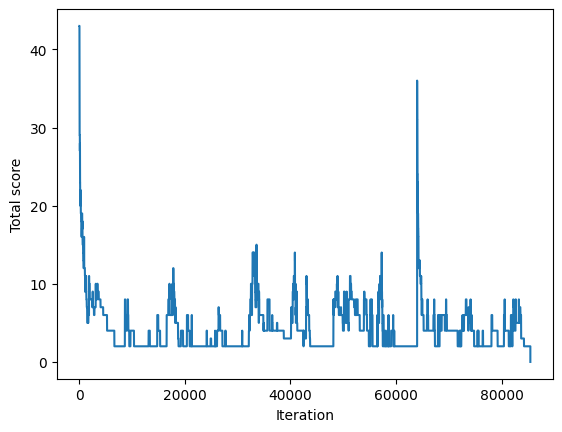

In [9]:
# Between 1 and 50
NUMBER = 18

unsolved_sudoku = read_sudoku_from_file(
    os.path.join("sudokus", "veryhard", f"{NUMBER}.txt")
)

sudoku = deepcopy(unsolved_sudoku)
results = solve(sudoku)

print_sudoku(unsolved_sudoku, solved_sudoku=sudoku)
print("Score: " + str(calculate_score(sudoku)))

plt.plot([i for i in range(len(results))], results)
plt.xlabel("Iteration")
plt.ylabel("Total score")

# Full report:

Sudoku 1
Iterations: 17192
Time elapsed: 1s

Sudoku 2
Iterations: 140363
Time elapsed: 7s

Sudoku 3
Iterations: 263406
Time elapsed: 10s

Sudoku 4
Iterations: 30795
Time elapsed: 1s

Sudoku 5
Iterations: 2511
Time elapsed: 0s

Sudoku 6
Iterations: 191733
Time elapsed: 7s

Sudoku 7
Iterations: 210808
Time elapsed: 8s

Sudoku 8
Iterations: 4941
Time elapsed: 0s

Sudoku 9
Iterations: 52430
Time elapsed: 2s

Sudoku 10
Iterations: 28235
Time elapsed: 1s

Sudoku 11
Iterations: 177729
Time elapsed: 7s

Sudoku 12
Iterations: 11212
Time elapsed: 0s

Sudoku 13
Iterations: 266884
Time elapsed: 10s

Sudoku 14
Iterations: 33787
Time elapsed: 1s

Sudoku 15
Iterations: 419787
Time elapsed: 16s

Sudoku 16
Iterations: 619
Time elapsed: 0s

Sudoku 17
Iterations: 1669
Time elapsed: 0s

Sudoku 18
Iterations: 19062
Time elapsed: 1s

Sudoku 19
Iterations: 11954
Time elapsed: 0s

Sudoku 20
Iterations: 4946
Time elapsed: 0s

Sudoku 21
Iterations: 8373
Time elapsed: 0s

Sudoku 22
Iterations: 328080
Time elapsed: 12s

Sudoku 23
Iterations: 23637
Time elapsed: 1s

Sudoku 24
Iterations: 4523
Time elapsed: 0s

Sudoku 25
Iterations: 232256
Time elapsed: 9s

Sudoku 26
Iterations: 542349
Time elapsed: 20s

Sudoku 27
Iterations: 165822
Time elapsed: 6s

Sudoku 28
Iterations: 17860
Time elapsed: 1s

Sudoku 29
Iterations: 339864
Time elapsed: 13s

Sudoku 30
Iterations: 97541
Time elapsed: 4s

Sudoku 31
Iterations: 340916
Time elapsed: 13s

Sudoku 32
Iterations: 548008
Time elapsed: 20s

Sudoku 33
Iterations: 14700
Time elapsed: 1s

Sudoku 34
Iterations: 19907
Time elapsed: 1s

Sudoku 35
Iterations: 31922
Time elapsed: 1s

Sudoku 36
Iterations: 128915
Time elapsed: 5s

Sudoku 37
Iterations: 33435
Time elapsed: 1s

Sudoku 38
Iterations: 2569
Time elapsed: 0s

Sudoku 39
Iterations: 10883
Time elapsed: 0s

Sudoku 40
Iterations: 28077
Time elapsed: 1s

Sudoku 41
Iterations: 188414
Time elapsed: 7s

Sudoku 42
Iterations: 38307
Time elapsed: 1s

Sudoku 43
Iterations: 554348
Time elapsed: 21s

Sudoku 44
Iterations: 15735
Time elapsed: 1s

Sudoku 45
Iterations: 26968
Time elapsed: 1s

Sudoku 46
Iterations: 12311
Time elapsed: 0s

Sudoku 47
Iterations: 1604913
Time elapsed: 1.0min 1s

Sudoku 48
Iterations: 888621
Time elapsed: 33s

Sudoku 49
Iterations: 351147
Time elapsed: 13s

Sudoku 50
Iterations: 115785
Time elapsed: 4s


## Generating report


In [10]:
iterations, time_measurements = generate_report()

Sudoku 1
Iterations: 54479
Time elapsed: 1s

Sudoku 2
Iterations: 18440
Time elapsed: 0s

Sudoku 3
Iterations: 60885
Time elapsed: 2s

Sudoku 4
Iterations: 39745
Time elapsed: 1s

Sudoku 5
Iterations: 2258
Time elapsed: 0s

Sudoku 6
Iterations: 255224
Time elapsed: 6s

Sudoku 7
Iterations: 60030
Time elapsed: 1s

Sudoku 8
Iterations: 2448
Time elapsed: 0s

Sudoku 9
Iterations: 69812
Time elapsed: 2s

Sudoku 10
Iterations: 110588
Time elapsed: 3s

Sudoku 11
Iterations: 131001
Time elapsed: 3s

Sudoku 12
Iterations: 19510
Time elapsed: 0s

Sudoku 13
Iterations: 249487
Time elapsed: 6s

Sudoku 14
Iterations: 36921
Time elapsed: 1s

Sudoku 15
Iterations: 34367
Time elapsed: 1s

Sudoku 16
Iterations: 1227
Time elapsed: 0s

Sudoku 17
Iterations: 1230
Time elapsed: 0s

Sudoku 18
Iterations: 12372
Time elapsed: 0s

Sudoku 19
Iterations: 19932
Time elapsed: 0s

Sudoku 20
Iterations: 15637
Time elapsed: 0s

Sudoku 21
Iterations: 67786
Time elapsed: 2s

Sudoku 22
Iterations: 614084
Time elapsed: 

Text(0, 0.5, 'Number of iterations')

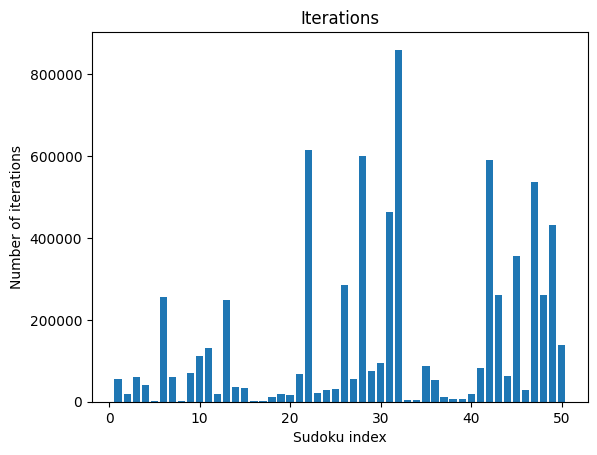

In [13]:
plt.bar([i + 1 for i in range(len(iterations))], iterations)

plt.title("Iterations")
plt.xlabel("Sudoku index")
plt.ylabel("Number of iterations")

Text(0, 0.5, 'Time measured [s]')

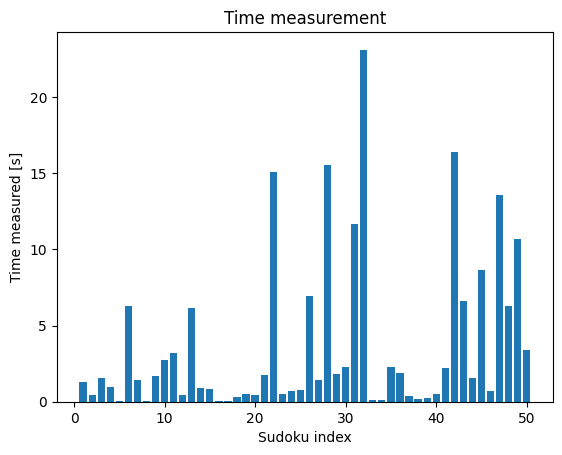

In [14]:
plt.bar([i + 1 for i in range(len(time_measurements))], time_measurements)

plt.title("Time measurement")
plt.xlabel("Sudoku index")
plt.ylabel("Time measured [s]")